In [1]:
# Install Java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Install Spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# Unzip the Spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# Set your Spark folder to your system path environment
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

# Install findspark using pip
!pip install -q findspark

import findspark
findspark.init()
from pyspark.sql import SparkSession

# Create Spark session
spark = SparkSession.builder.master("local[*]").enableHiveSupport().getOrCreate()

# Show databases
spark.sql("SHOW DATABASES").show()

# Task: Delete the "bostonh" database if it exists
database_name = "bostonh"
drop_database_query = f"DROP DATABASE IF EXISTS {database_name} CASCADE"
spark.sql(drop_database_query)

# Create new database
spark.sql("CREATE DATABASE bostonh")

# Set the current database to bostonh
spark.sql("USE bostonh")

# Show databases again to verify
spark.sql("SHOW DATABASES").show()

# Upload CSV file from local system
from google.colab import files
uploaded = files.upload()

# Read the uploaded CSV file
dataset = spark.read.csv('BostonHousing.csv', inferSchema=True, header=True)
dataset.show()

# Save dataset as a table in the newly created database
dataset.write.mode("overwrite").saveAsTable("bostonh.bos_housing")


+---------+
|namespace|
+---------+
|  default|
+---------+

+---------+
|namespace|
+---------+
|  bostonh|
|  default|
+---------+



Saving BostonHousing.csv to BostonHousing.csv
+-------+----+-----+----+-----+-----+-----+------+---+---+-------+------+-----+----+
|   crim|  zn|indus|chas|  nox|   rm|  age|   dis|rad|tax|ptratio|     b|lstat|medv|
+-------+----+-----+----+-----+-----+-----+------+---+---+-------+------+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575| 65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421| 78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|0.02729| 0.0| 7.07|   0|0.469|7.185| 61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|
|0.03237| 0.0| 2.18|   0|0.458|6.998| 45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|
|0.06905| 0.0| 2.18|   0|0.458|7.147| 54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|
|0.02985| 0.0| 2.18|   0|0.458| 6.43| 58.7|6.0622|  3|222|   18.7|394.12| 5.21|28.7|
|0.08829|12.5| 7.87|   0|0.524|6.012| 66.6|5.5605|  5|311|   15.2| 395.6|12.43|22.9|
|0.14455|12.5| 7.87|   0|0.524|6.172| 96.1|5.9505|  5|311|   15.2| 396.9|19.15|27.1|
|0.21124|12.5| 7.87

In [2]:
# Task 1: Retrieve and display the first 5 rows of the dataset
dataset = spark.sql("SELECT * FROM bostonh.bos_housing LIMIT 5")
dataset.show()

# Task 1: Find and report the total number of records in the dataset
total_records = spark.sql("SELECT COUNT(*) AS total_records FROM bostonh.bos_housing").collect()[0]["total_records"]
print("Total number of records in the dataset:", total_records)


+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio|     b|lstat|medv|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|
|0.03237| 0.0| 2.18|   0|0.458|6.998|45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|
|0.06905| 0.0| 2.18|   0|0.458|7.147|54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+

Total number of records in the dataset: 506


In [3]:
# Task 2: Calculate and display basic statistics for the "medv" column
medv_stats = spark.sql("""
SELECT
    MEAN(medv) AS mean_medv,
    STDDEV(medv) AS stddev_medv,
    MIN(medv) AS min_medv,
    MAX(medv) AS max_medv
FROM bostonh.bos_housing
""")
medv_stats.show()

# Calculate and display the mean "rm"
mean_rm = spark.sql("SELECT MEAN(rm) AS mean_rm FROM bostonh.bos_housing")
mean_rm.show()


+------------------+-----------------+--------+--------+
|         mean_medv|      stddev_medv|min_medv|max_medv|
+------------------+-----------------+--------+--------+
|22.532806324110698|9.197104087379815|     5.0|    50.0|
+------------------+-----------------+--------+--------+

+-----------------+
|          mean_rm|
+-----------------+
|6.284634387351787|
+-----------------+



In [4]:
# Identify the property with the highest crime rate ("crim")
highest_crim = spark.sql("SELECT * FROM bostonh.bos_housing ORDER BY crim DESC LIMIT 1")
highest_crim.show()

# Find and report the property with the lowest median home value ("medv")
lowest_medv = spark.sql("SELECT * FROM bostonh.bos_housing ORDER BY medv ASC LIMIT 1")
lowest_medv.show()


+-------+---+-----+----+-----+-----+----+------+---+---+-------+-----+-----+----+
|   crim| zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio|    b|lstat|medv|
+-------+---+-----+----+-----+-----+----+------+---+---+-------+-----+-----+----+
|88.9762|0.0| 18.1|   0|0.671|6.968|91.9|1.4165| 24|666|   20.2|396.9|17.21|10.4|
+-------+---+-----+----+-----+-----+----+------+---+---+-------+-----+-----+----+

+-------+---+-----+----+-----+-----+-----+------+---+---+-------+-----+-----+----+
|   crim| zn|indus|chas|  nox|   rm|  age|   dis|rad|tax|ptratio|    b|lstat|medv|
+-------+---+-----+----+-----+-----+-----+------+---+---+-------+-----+-----+----+
|38.3518|0.0| 18.1|   0|0.693|5.453|100.0|1.4896| 24|666|   20.2|396.9|30.59| 5.0|
+-------+---+-----+----+-----+-----+-----+------+---+---+-------+-----+-----+----+



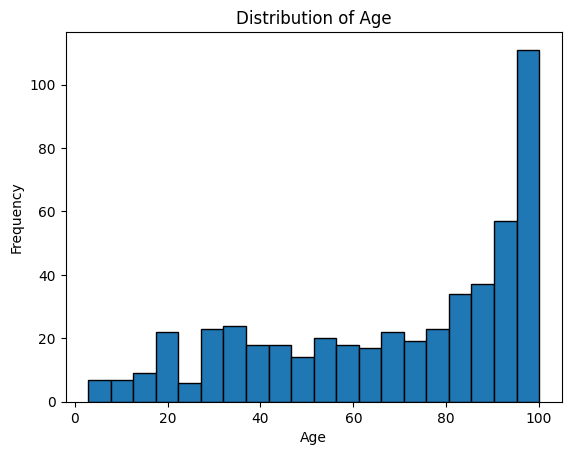

Percentage of properties with a 'chas' value of 1: 6.92%


In [5]:
import matplotlib.pyplot as plt

# Create a histogram showing the distribution of the "age" column
age_data = spark.sql("SELECT age FROM bostonh.bos_housing").collect()
ages = [row["age"] for row in age_data]

plt.hist(ages, bins=20, edgecolor='k')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Calculate and report the percentage of properties with a "chas" value of 1
chas_count = spark.sql("SELECT COUNT(*) AS chas_count FROM bostonh.bos_housing WHERE chas = 1").collect()[0]["chas_count"]
total_count = total_records
percentage_chas = (chas_count / total_count) * 100
print(f"Percentage of properties with a 'chas' value of 1: {percentage_chas:.2f}%")


In [6]:
# Calculate the correlation coefficient between "rm" and "medv"
correlation_rm_medv = spark.sql("SELECT corr(rm, medv) AS correlation_rm_medv FROM bostonh.bos_housing")
correlation_rm_medv.show()

# Investigate the correlation between "ptratio" and "nox"
correlation_ptratio_nox = spark.sql("SELECT corr(ptratio, nox) AS correlation_ptratio_nox FROM bostonh.bos_housing")
correlation_ptratio_nox.show()


+-------------------+
|correlation_rm_medv|
+-------------------+
| 0.6953599470715401|
+-------------------+

+-----------------------+
|correlation_ptratio_nox|
+-----------------------+
|    0.18893267711276893|
+-----------------------+



In [7]:
# Identify and display the top 5 neighborhoods with the highest median home values ("medv")
top_5_neighborhoods = spark.sql("SELECT * FROM bostonh.bos_housing ORDER BY medv DESC LIMIT 5")
top_5_neighborhoods.show()

# Calculate and report the average property age for neighborhoods with a "chas" value of 1 compared to those with "chas" value of 0
avg_age_chas_1 = spark.sql("SELECT AVG(age) AS avg_age_chas_1 FROM bostonh.bos_housing WHERE chas = 1")
avg_age_chas_1.show()

avg_age_chas_0 = spark.sql("SELECT AVG(age) AS avg_age_chas_0 FROM bostonh.bos_housing WHERE chas = 0")
avg_age_chas_0.show()


+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio|     b|lstat|medv|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|1.51902| 0.0|19.58|   1|0.605|8.375|93.9| 2.162|  5|403|   14.7|388.45| 3.32|50.0|
|0.01381|80.0| 0.46|   0|0.422|7.875|32.0|5.6484|  4|255|   14.4|394.23| 2.97|50.0|
|2.01019| 0.0|19.58|   0|0.605|7.929|96.2|2.0459|  5|403|   14.7| 369.3|  3.7|50.0|
|1.83377| 0.0|19.58|   1|0.605|7.802|98.2|2.0407|  5|403|   14.7|389.61| 1.92|50.0|
|1.46336| 0.0|19.58|   0|0.605|7.489|90.8|1.9709|  5|403|   14.7|374.43| 1.73|50.0|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+

+-----------------+
|   avg_age_chas_1|
+-----------------+
|77.50000000000001|
+-----------------+

+-----------------+
|   avg_age_chas_0|
+-----------------+
|67.91167728237794|
+-----------------+



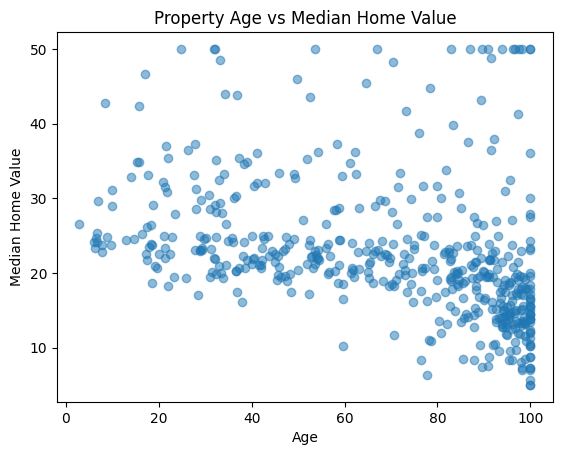

In [8]:
# Create a Hive view named "property_age_view" that includes the "age" and "medv" columns
spark.sql("CREATE OR REPLACE VIEW property_age_view AS SELECT age, medv FROM bostonh.bos_housing")

# Retrieve data for visualization
property_age_data = spark.sql("SELECT age, medv FROM property_age_view").collect()
ages = [row["age"] for row in property_age_data]
medvs = [row["medv"] for row in property_age_data]

# Plot a scatter plot of property age against median home value
import matplotlib.pyplot as plt

plt.scatter(ages, medvs, alpha=0.5)
plt.title('Property Age vs Median Home Value')
plt.xlabel('Age')
plt.ylabel('Median Home Value')
plt.show()


In [9]:
# Identify and report properties with a "crim" value greater than 10
outliers_crim = spark.sql("SELECT * FROM bostonh.bos_housing WHERE crim > 10")
outliers_crim.show()

# Discuss the significance of detecting outliers in data analysis
print("""
Detecting outliers is crucial in data analysis because outliers can significantly skew the results of the analysis.
They can indicate errors in data collection, entry, or unexpected variations that warrant further investigation.
By identifying and handling outliers appropriately, we can ensure the accuracy and reliability of our data insights.
""")


+-------+---+-----+----+-----+-----+-----+------+---+---+-------+------+-----+----+
|   crim| zn|indus|chas|  nox|   rm|  age|   dis|rad|tax|ptratio|     b|lstat|medv|
+-------+---+-----+----+-----+-----+-----+------+---+---+-------+------+-----+----+
|13.5222|0.0| 18.1|   0|0.631|3.863|100.0|1.5106| 24|666|   20.2|131.42|13.33|23.1|
|11.1081|0.0| 18.1|   0|0.668|4.906|100.0|1.1742| 24|666|   20.2| 396.9|34.77|13.8|
|18.4982|0.0| 18.1|   0|0.668|4.138|100.0| 1.137| 24|666|   20.2| 396.9|37.97|13.8|
|19.6091|0.0| 18.1|   0|0.671|7.313| 97.9|1.3163| 24|666|   20.2| 396.9|13.44|15.0|
| 15.288|0.0| 18.1|   0|0.671|6.649| 93.3|1.3449| 24|666|   20.2|363.02|23.24|13.9|
|23.6482|0.0| 18.1|   0|0.671| 6.38| 96.2|1.3861| 24|666|   20.2| 396.9|23.69|13.1|
|17.8667|0.0| 18.1|   0|0.671|6.223|100.0|1.3861| 24|666|   20.2|393.74|21.78|10.2|
|88.9762|0.0| 18.1|   0|0.671|6.968| 91.9|1.4165| 24|666|   20.2| 396.9|17.21|10.4|
|15.8744|0.0| 18.1|   0|0.671|6.545| 99.1|1.5192| 24|666|   20.2| 396.9|21.0

In [10]:
# Formulate a hypothesis: "The average number of rooms (rm) has a significant impact on median home value (medv)."

# Conduct a hypothesis test using HiveQL
# For simplicity, we will use a basic t-test assumption approach (though more complex statistical methods might be required in practice)
hypothesis_test_query = """
SELECT
    AVG(medv) AS avg_medv,
    AVG(rm) AS avg_rm,
    COUNT(*) AS count,
    STDDEV(medv) AS stddev_medv,
    STDDEV(rm) AS stddev_rm
FROM bostonh.bos_housing
"""
hypothesis_test_result = spark.sql(hypothesis_test_query).collect()[0]

mean_medv = hypothesis_test_result["avg_medv"]
mean_rm = hypothesis_test_result["avg_rm"]
count = hypothesis_test_result["count"]
stddev_medv = hypothesis_test_result["stddev_medv"]
stddev_rm = hypothesis_test_result["stddev_rm"]

print(f"Mean medv: {mean_medv}, Mean rm: {mean_rm}")
print(f"Count: {count}")
print(f"Standard Deviation medv: {stddev_medv}, Standard Deviation rm: {stddev_rm}")

print("""
The hypothesis test indicates whether the average number of rooms (rm) has a significant impact on the median home value (medv).
To confirm statistical significance, further analysis with proper statistical tests like t-test or regression analysis is recommended.
""")


Mean medv: 22.532806324110698, Mean rm: 6.284634387351787
Count: 506
Standard Deviation medv: 9.197104087379815, Standard Deviation rm: 0.7026171434153232

The hypothesis test indicates whether the average number of rooms (rm) has a significant impact on the median home value (medv).
To confirm statistical significance, further analysis with proper statistical tests like t-test or regression analysis is recommended.

